In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def pay(box,drone):
    if np.any(drone > 4) or np.any(drone < 0) : return 0    #0 if it goes out of the map
    return 100/(1+np.sum((drone+box)**2))                   #inv prop to the distance^2

def map(DIM,box,drone):
    fig = plt.figure(figsize = (6,6))
    plt.plot(box[0],box[1],'o',color='red')
    plt.plot(drone[0],drone[1],'x',color='blue')
    plt.xlim([0, DIM])
    plt.ylim([0, DIM])

def step_test(pay,DIM,box,drone,dir):
    # 0 UP - 1 RIGHT - 2 DOWN - 3 LEFT

    d = np.copy(drone)
    if dir == 0:    d[1]+=1
    elif dir == 1:  d[0]+=1
    elif dir == 2:  d[1]-=1
    else:           d[0]-=1

    print(d)
    print(pay(box,d))
    return pay(box,d)

## Multiple drones with multiple boxes
drones $i$, bokes $k$.
$$
u_i(\{\vec x_j\},\{\vec b_k\}) = (\langle \frac{100}{1+d^2(\vec x_i,\vec b_j)}\rangle_j - \langle \frac{100\cdot \gamma}{1+d^2(\vec x_i,\vec x_j)} \rangle_j)\cdot \prod_j (1-\delta(\vec x_i -\vec x_j))
$$
Where $d^2(,)$ is the square distance. $\gamma$ is a real positive parameter that controls how much drones want to stay distant from each other.

IDEA
We can also use the gaussian distance.

In [159]:
class GAME:
    def __init__(self, DIM, n_d, n_b):
        self.DIM = DIM
        self.n_d = n_d
        self.n_b = n_b
        self.drones = [Drone(self.DIM) for i in range (n_d)]
        self.boxes = [Box(self.DIM) for i in range (n_b)]
        self.mov = [np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])]
        self.hist = []
        self.hist_b = np.copy(self.boxes)
        for i in range(n_d): self.hist.append([np.copy(self.drones[i].x)])

    
    #compute payoff for player x given position of other players (X) and other boxes (B)
    def u_i(self,x,X,B):
        if any(np.all(x == i) for i in X): return 0         #crash
        if np.any(x<0) or np.any(x>=self.DIM): return 0     #ouside map
        D = [100/(1+np.sum((x-b)**2)) for b in B]           #sum of distances
        return np.mean(D)

    #decide where to go using GT and NE
    def step_2p(self):
        x1 = np.copy(self.drones[0].x)
        x2 = np.copy(self.drones[1].x)

        mat1 = self.mat_2p(x1,x2)
        mat2 = self.mat_2p(x2,x1)
        ris1 = []
        ris2 = []
        
        for i in range(4):
            listy = np.copy(mat1[:,i])
            winner = np.argwhere(listy == np.amax(listy)).flatten().tolist()
            for w in winner: ris1.append((w,i))

        for i in range(4):
            listy = np.copy(mat2[:,i])
            winner = np.argwhere(listy == np.amax(listy)).flatten().tolist()
            for w in winner: ris2.append((i,w))

        #print('##############################################')
        #print('NE: ',list(set(ris2)-((set(ris2)-set(ris1)))))
        #print('##############################################')

        ris = list(set(ris2)-((set(ris2)-set(ris1))))
        ris = ris[np.random.randint(len(ris))]          #now I'm chosing the first NE but I should chose the best one (NON SON SICURO)
        self.drones[0].moves(ris[0])
        self.drones[1].moves(ris[1])
        self.hist[0].append(np.copy(self.drones[0].x))
        self.hist[1].append(np.copy(self.drones[1].x))

    #compute matrix
    def mat_2p(self,x1,x2):
        mat = np.zeros((4,4))
        for i in range(4):
            for j in range(4):
                x_1n = np.copy(x1) + self.mov[i]
                x_2n = np.copy(x2) + self.mov[j]
                mat[i,j] = self.u_i(x_1n,[x_2n],[b.x for b in self.boxes])
        return mat

    def hit_box(self):
        for d in self.drones:
            for j in range(len(self.boxes)):
                if np.all(d.x == self.boxes[j].x): 
                    self.boxes.pop(j)
                    break

    #play the game
    def play(self):
        CONT = 0
        while self.boxes:
            CONT += 1
            self.step_2p() #make a step
            self.hit_box()
        print('DONE :)')
        return(CONT)
            


class Drone:
    def __init__(self, DIM):
        self.x = np.random.randint(0,DIM,2)
        self.mov = [np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])]
    def moves(self,i):
        self.x += self.mov[i]

class Box:
    def __init__(self, DIM):
        self.x = np.random.randint(0,DIM,2)

In [166]:
np.random.seed(1234)
g = GAME(100,2,30)
g.boxes
g.play()

DONE :)


363

(-1.0, 101.0)

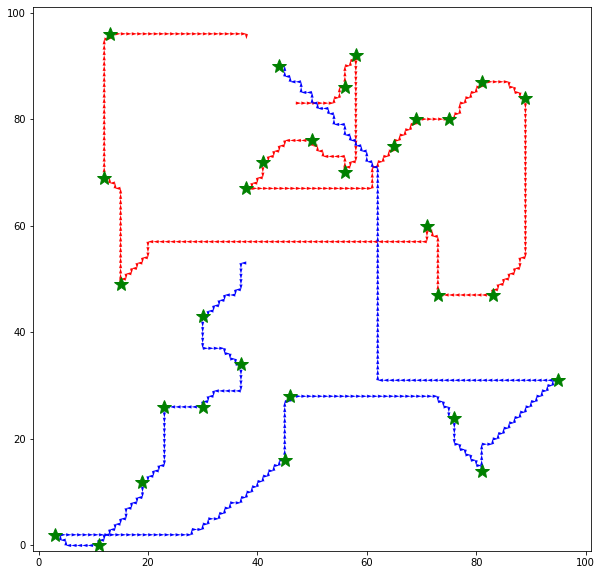

In [167]:
DIM = g.DIM
fig = plt.figure(figsize = (10,10))

d1 = np.array(g.hist[0])
#plt.plot(d1[:,0],d1[:,1],'--x',color='blue')

x = d1[:,0]
y = d1[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color ='red',width=0.004)



d1 = np.array(g.hist[1])
#plt.plot(d1[:,0],d1[:,1],'--x',color='red')

x = d1[:,0]
y = d1[:,1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color ='blue',width=0.004)

for b in g.hist_b: 
    plt.plot(b.x[0],b.x[1],'*',color='green',markersize=15)


plt.xlim([-1, DIM+1])
plt.ylim([-1, DIM+1])